## Setup

In [67]:
%matplotlib inline

In [68]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [69]:
from aif360.datasets import StandardDataset
StandardDataset??

In [70]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGRMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 

## Arguments & Initializations

In [71]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade ")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")

_StoreAction(option_strings=['-o', '--os'], dest='os', nargs=None, const=None, default=2, type=None, choices=None, required=False, help='oversample mode: 1: privi unfav 2: unpriv fav', metavar=None)

In [72]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [73]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2}

In [74]:
DATASET = "law_sex"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])

In [75]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 3 

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

egr_metrics = defaultdict(list) 
egr_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [76]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

# training data split ratio
p = 0.5

Categorical Variables []
Categorical Variables []


In [77]:
dataset_orig.features.shape

(20798, 19)

In [78]:
privileged_groups

[{'gender': 1}]

In [79]:
# split dataset into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
dataset_orig_val = dataset_orig_test
print(dataset_orig_train.features)

[[2. 2. 7. ... 4. 6. 8.]
 [3. 2. 3. ... 3. 2. 2.]
 [8. 8. 7. ... 6. 6. 8.]
 ...
 [9. 8. 7. ... 5. 6. 8.]
 [6. 6. 7. ... 3. 5. 5.]
 [5. 9. 7. ... 3. 5. 5.]]


In [80]:
# NOT SUITABLE
# favorable and unfavorable labels and feature_names
f_label = dataset_orig_train.favorable_label
uf_label = dataset_orig_train.unfavorable_label
feature_names = dataset_orig_train.feature_names

# introduce label or selection biases, assuming the original data is fair
if BIAS_TYPE == 'label':
    dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
elif BIAS_TYPE == 'selection':
    dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
else:
    print('no bias type specified')

no bias type specified


In [81]:
dataset_orig_train

               instance weights features features features features features  \
                                                                               
                                 decile3  decile1     race  cluster     lsat   
instance names                                                                 
85                          1.0      2.0      2.0      7.0      1.0     42.0   
14508                       1.0      3.0      2.0      3.0      3.0     17.5   
12515                       1.0      8.0      8.0      7.0      5.0     48.0   
7320                        1.0      1.0      1.0      7.0      1.0     37.0   
8399                        1.0      2.0      2.0      7.0      1.0     36.0   
...                         ...      ...      ...      ...      ...      ...   
12585                       1.0      6.0      7.0      7.0      3.0     33.0   
12960                       1.0      2.0      3.0      7.0      1.0     36.0   
3621                        1.0      9.0

In [82]:
dataset_orig_train?

## Run Mitigating Algorithms

In [83]:
# run mitigating algorithms
for i in range(N):
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print("#### Train dataset's features are as below:")
    print(dataset_orig_train.features)

    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    feature_names = dataset_orig_train.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, OS_MODE, SCALER)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # egr mitigator, in-processing
    egr_metrics, egr_mia_metrics = test_cases.run_egr(dataset_orig_train, dataset_orig_val, dataset_orig_test, egr_metrics, egr_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups,THRESH_ARR, DISPLAY, SCALER)
    # egr gave error so I replaced it with reweigh
#     egr_metrics, egr_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, egr_metrics, egr_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    # ro mitigator
    # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    if (BASELINE == 'lr'):
        pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

#### Train dataset's features are as below:
[[ 9.  9.  7. ...  2.  6.  6.]
 [ 1.  1.  3. ...  6.  4.  4.]
 [ 9. 10.  7. ...  4.  6.  8.]
 ...
 [ 2.  4.  1. ...  2.  6.  7.]
 [ 6.  8.  7. ...  4.  6.  8.]
 [ 1.  1.  3. ...  4.  2.  2.]]
no bias type specified
#### Training Dataset shape
(10399, 19)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['gender']
#### Privileged and unprivileged protected groups
[{'gender': 1}] [{'gender': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['decile3', 'decile1', 'race', 'cluster', 'lsat', 'ugpa', 'dob_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'race2', 'other', 'asian', 'black', 'hisp', 'tier', 'indxgrp', 'indxgrp2']
privileged vs. unprivileged:  5783.0 4616.0
base_pos unpriv:  0.936525129982669
base_pos priv:  0.9510634618710012
number of favorable labels:  9823
Difference in mean outcomes between unprivileged and privileged groups = -0.014538
#

origin, transf:  10399 11770
after transf priv:  0.9510634618710012
after transf unpriv:  0.9510606313679639
Difference in mean outcomes between unprivileged and privileged groups = -0.000003
[INFO]: training decision tree
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.84      0.48      0.61       576
         1.0       0.97      1.00      0.98     11194

    accuracy                           0.97     11770
   macro avg       0.91      0.74      0.80     11770
weighted avg       0.97      0.97      0.97     11770

Train accuracy:  0.9700934579439252
Validating Original ...
Accuracy for threshold: 0.01  is: 0.9466294836041927
Balanced accuracy is:  0.5539739990975826
Accuracy for threshold: 0.02  is: 0.9466294836041927
Balanced accuracy is:  0.5539739990975826
Accuracy for threshold: 0.03  is: 0.9466294836041927
Balanced accuracy is:  0.5539739990975826
Accuracy for threshold: 0.04  is: 0.9466294836041927
Bal

[INFO]: training decision tree
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.91      0.47      0.62       576
         1.0       0.97      1.00      0.98      9823

    accuracy                           0.97     10399
   macro avg       0.94      0.73      0.80     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9679776901625157
Validating Original ...
Accuracy for threshold: 0.01  is: 0.9432637753630156
Balanced accuracy is:  0.5481035133540427
Accuracy for threshold: 0.02  is: 0.9432637753630156
Balanced accuracy is:  0.5481035133540427
Accuracy for threshold: 0.03  is: 0.9432637753630156
Balanced accuracy is:  0.5481035133540427
Accuracy for threshold: 0.04  is: 0.9432637753630156
Balanced accuracy is:  0.5481035133540427
Accuracy for threshold: 0.05  is: 0.9432637753630156
Balanced accuracy is:  0.5481035133540427
Accuracy for threshold: 0.060000000000000005  is: 0.94

Accuracy for threshold: 0.01  is: 0.9429752860852005
Balanced accuracy is:  0.560279640941985
Accuracy for threshold: 0.02  is: 0.9429752860852005
Balanced accuracy is:  0.560279640941985
Accuracy for threshold: 0.03  is: 0.9429752860852005
Balanced accuracy is:  0.560279640941985
Accuracy for threshold: 0.04  is: 0.9429752860852005
Balanced accuracy is:  0.560279640941985
Accuracy for threshold: 0.05  is: 0.9429752860852005
Balanced accuracy is:  0.560279640941985
Accuracy for threshold: 0.060000000000000005  is: 0.9429752860852005
Balanced accuracy is:  0.560279640941985
Accuracy for threshold: 0.06999999999999999  is: 0.9429752860852005
Balanced accuracy is:  0.560279640941985
Accuracy for threshold: 0.08  is: 0.9429752860852005
Balanced accuracy is:  0.560279640941985
Accuracy for threshold: 0.09  is: 0.9426867968073853
Balanced accuracy is:  0.5632104368047481
Accuracy for threshold: 0.09999999999999999  is: 0.9426867968073853
Balanced accuracy is:  0.5632104368047481
Accuracy for

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Type of dataset after EGR: <class 'aif360.algorithms.inprocessing.exponentiated_gradient_reduction.ExponentiatedGradientReduction'>
Attributes of dataset after EGR:
['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_params', 'fit', 'fit_predict', 'fit_transform', 'model', 'predict', 'transform']
y_val_pred_prob:  [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Accuracy for threshold: 0.01  is: 0.9512453120492355
Balanced accuracy is:  0.5399535558717873
Accuracy for threshold: 0.02  is: 0.9512453120492355
Balanced accuracy is:  0.5399535558717873
Accuracy for threshold: 0.03  is: 0.9512453120492355
Balanced accuracy is:  0.5399535558717873
Accuracy f

Accuracy for threshold: 0.26  is: 0.943840753918646
Balanced accuracy is:  0.5720324349652048
Accuracy for threshold: 0.27  is: 0.943840753918646
Balanced accuracy is:  0.5720324349652048
Accuracy for threshold: 0.28  is: 0.943840753918646
Balanced accuracy is:  0.5720324349652048
Accuracy for threshold: 0.29000000000000004  is: 0.943840753918646
Balanced accuracy is:  0.5720324349652048
Accuracy for threshold: 0.3  is: 0.943840753918646
Balanced accuracy is:  0.5720324349652048
Accuracy for threshold: 0.31  is: 0.943840753918646
Balanced accuracy is:  0.5720324349652048
Accuracy for threshold: 0.32  is: 0.943840753918646
Balanced accuracy is:  0.5720324349652048
Accuracy for threshold: 0.33  is: 0.943840753918646
Balanced accuracy is:  0.5720324349652048
Accuracy for threshold: 0.34  is: 0.9432637753630156
Balanced accuracy is:  0.5737849903684292
Accuracy for threshold: 0.35000000000000003  is: 0.9432637753630156
Balanced accuracy is:  0.5737849903684292
Accuracy for threshold: 0.360

Accuracy for threshold: 0.08  is: 0.942109818251755
Balanced accuracy is:  0.5641558554860917
Accuracy for threshold: 0.09  is: 0.942109818251755
Balanced accuracy is:  0.5641558554860917
Accuracy for threshold: 0.09999999999999999  is: 0.942109818251755
Balanced accuracy is:  0.5641558554860917
Accuracy for threshold: 0.11  is: 0.942109818251755
Balanced accuracy is:  0.5641558554860917
Accuracy for threshold: 0.12  is: 0.942109818251755
Balanced accuracy is:  0.5641558554860917
Accuracy for threshold: 0.13  is: 0.942109818251755
Balanced accuracy is:  0.5641558554860917
Accuracy for threshold: 0.14  is: 0.942109818251755
Balanced accuracy is:  0.5641558554860917
Accuracy for threshold: 0.15000000000000002  is: 0.9422059813443601
Balanced accuracy is:  0.5660660785701681
Accuracy for threshold: 0.16  is: 0.9422059813443601
Balanced accuracy is:  0.5660660785701681
Accuracy for threshold: 0.17  is: 0.942109818251755
Balanced accuracy is:  0.5678751791949463
Accuracy for threshold: 0.18

Accuracy for threshold: 0.26  is: 0.9427829598999904
Balanced accuracy is:  0.5663694459480627
Accuracy for threshold: 0.27  is: 0.9427829598999904
Balanced accuracy is:  0.5663694459480627
Accuracy for threshold: 0.28  is: 0.9427829598999904
Balanced accuracy is:  0.5663694459480627
Accuracy for threshold: 0.29000000000000004  is: 0.9427829598999904
Balanced accuracy is:  0.5663694459480627
Accuracy for threshold: 0.3  is: 0.9427829598999904
Balanced accuracy is:  0.5663694459480627
Accuracy for threshold: 0.31  is: 0.9427829598999904
Balanced accuracy is:  0.5663694459480627
Accuracy for threshold: 0.32  is: 0.9427829598999904
Balanced accuracy is:  0.5663694459480627
Accuracy for threshold: 0.33  is: 0.9427829598999904
Balanced accuracy is:  0.5663694459480627
Accuracy for threshold: 0.34  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.35000000000000003  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshol

Accuracy for threshold: 0.25  is: 0.9391287623809982
Balanced accuracy is:  0.566307781075824
Accuracy for threshold: 0.26  is: 0.9391287623809982
Balanced accuracy is:  0.566307781075824
Accuracy for threshold: 0.27  is: 0.9391287623809982
Balanced accuracy is:  0.566307781075824
Accuracy for threshold: 0.28  is: 0.9391287623809982
Balanced accuracy is:  0.566307781075824
Accuracy for threshold: 0.29000000000000004  is: 0.9391287623809982
Balanced accuracy is:  0.566307781075824
Accuracy for threshold: 0.3  is: 0.9391287623809982
Balanced accuracy is:  0.566307781075824
Accuracy for threshold: 0.31  is: 0.9391287623809982
Balanced accuracy is:  0.566307781075824
Accuracy for threshold: 0.32  is: 0.9391287623809982
Balanced accuracy is:  0.566307781075824
Accuracy for threshold: 0.33  is: 0.9391287623809982
Balanced accuracy is:  0.566307781075824
Accuracy for threshold: 0.34  is: 0.9382632945475526
Balanced accuracy is:  0.5658527300089821
Accuracy for threshold: 0.35000000000000003  

Accuracy for threshold: 0.5  is: 0.9403788825848639
Balanced accuracy is:  0.5688247389156896
Best thresh:  0.47000000000000003
Best balanced accuracy: 0.5688
Corresponding 1-min(DI, 1/DI) value: 0.9900
Corresponding average odds difference value: -0.0161
Corresponding statistical parity difference value: -0.0098
Corresponding equal opportunity difference value: -0.0078
Corresponding Theil index value: 0.0332
Corresponding false positive_rate for privileged: 0.8550
Corresponding false negative_rate for privileged: 0.0158
Corresponding false positive_rate for unpribileged: 0.8306
Corresponding false negative_rate for unprivileged: 0.0236
Testing Original ...
True positive rate is:  0.98078673273334
True negative rate is:  0.1568627450980392
Balanced accuracy is:  0.5688247389156896
Test Accuracy is:  0.9403788825848639
Best balanced accuracy: 0.5688
Corresponding 1-min(DI, 1/DI) value: 0.9900
Corresponding average odds difference value: -0.0161
Corresponding statistical parity differenc

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Type of dataset after EGR: <class 'aif360.algorithms.inprocessing.exponentiated_gradient_reduction.ExponentiatedGradientReduction'>
Attributes of dataset after EGR:
['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_params', 'fit', 'fit_predict', 'fit_transform', 'model', 'predict', 'transform']
y_val_pred_prob:  [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Accuracy for threshold: 0.01  is: 0.9495143763823445
Balanced accuracy is:  0.5382944804982362
Accuracy for threshold: 0.02  is: 0.9495143763823445
Balanced accuracy is:  0.5382944804982362
Accuracy for threshold: 0.03  is: 0.9495143763823445
Balanced accuracy is:  0.5382944804982362
Accuracy f

Accuracy for threshold: 0.32  is: 0.9412443504183095
Balanced accuracy is:  0.5655604662736771
Accuracy for threshold: 0.33  is: 0.9412443504183095
Balanced accuracy is:  0.5655604662736771
Accuracy for threshold: 0.34  is: 0.9408596980478893
Balanced accuracy is:  0.5672178832095078
Accuracy for threshold: 0.35000000000000003  is: 0.9408596980478893
Balanced accuracy is:  0.5672178832095078
Accuracy for threshold: 0.36000000000000004  is: 0.9408596980478893
Balanced accuracy is:  0.5672178832095078
Accuracy for threshold: 0.37  is: 0.9408596980478893
Balanced accuracy is:  0.5672178832095078
Accuracy for threshold: 0.38  is: 0.9408596980478893
Balanced accuracy is:  0.5672178832095078
Accuracy for threshold: 0.39  is: 0.9408596980478893
Balanced accuracy is:  0.5672178832095078
Accuracy for threshold: 0.4  is: 0.9408596980478893
Balanced accuracy is:  0.5672178832095078
Accuracy for threshold: 0.41000000000000003  is: 0.9408596980478893
Balanced accuracy is:  0.5672178832095078
Accura

Accuracy for threshold: 0.16  is: 0.9422059813443601
Balanced accuracy is:  0.5660660785701681
Accuracy for threshold: 0.17  is: 0.942109818251755
Balanced accuracy is:  0.5678751791949463
Accuracy for threshold: 0.18000000000000002  is: 0.942109818251755
Balanced accuracy is:  0.5678751791949463
Accuracy for threshold: 0.19  is: 0.9415328396961247
Balanced accuracy is:  0.5675718118170516
Accuracy for threshold: 0.2  is: 0.9415328396961247
Balanced accuracy is:  0.5675718118170516
Accuracy for threshold: 0.21000000000000002  is: 0.9415328396961247
Balanced accuracy is:  0.5675718118170516
Accuracy for threshold: 0.22  is: 0.9415328396961247
Balanced accuracy is:  0.5675718118170516
Accuracy for threshold: 0.23  is: 0.9415328396961247
Balanced accuracy is:  0.5675718118170516
Accuracy for threshold: 0.24000000000000002  is: 0.9415328396961247
Balanced accuracy is:  0.5675718118170516
Accuracy for threshold: 0.25  is: 0.9412443504183095
Balanced accuracy is:  0.5674201281281044
Accuracy

Accuracy for threshold: 0.28  is: 0.9427829598999904
Balanced accuracy is:  0.5663694459480627
Accuracy for threshold: 0.29000000000000004  is: 0.9427829598999904
Balanced accuracy is:  0.5663694459480627
Accuracy for threshold: 0.3  is: 0.9427829598999904
Balanced accuracy is:  0.5663694459480627
Accuracy for threshold: 0.31  is: 0.9427829598999904
Balanced accuracy is:  0.5663694459480627
Accuracy for threshold: 0.32  is: 0.9427829598999904
Balanced accuracy is:  0.5663694459480627
Accuracy for threshold: 0.33  is: 0.9427829598999904
Balanced accuracy is:  0.5663694459480627
Accuracy for threshold: 0.34  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.35000000000000003  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.36000000000000004  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.37  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accura

Accuracy for threshold: 0.48000000000000004  is: 0.9384556207327628
Balanced accuracy is:  0.5752521617404167
Accuracy for threshold: 0.49  is: 0.9384556207327628
Balanced accuracy is:  0.5752521617404167
Accuracy for threshold: 0.5  is: 0.9342244446581403
Balanced accuracy is:  0.5879047624712743
Best thresh:  0.5
Best balanced accuracy: 0.5879
Corresponding 1-min(DI, 1/DI) value: 0.9821
Corresponding average odds difference value: -0.0546
Corresponding statistical parity difference value: -0.0173
Corresponding equal opportunity difference value: -0.0116
Corresponding Theil index value: 0.0412
Corresponding false positive_rate for privileged: 0.8435
Corresponding false negative_rate for privileged: 0.0230
Corresponding false positive_rate for unpribileged: 0.7460
Corresponding false negative_rate for unprivileged: 0.0346
Testing Original ...
True positive rate is:  0.9718879563150976
True negative rate is:  0.20392156862745098
Balanced accuracy is:  0.5879047624712743
Test Accuracy is

Accuracy for threshold: 0.41000000000000003  is: 0.9419174920665448
Balanced accuracy is:  0.5594055783907252
Accuracy for threshold: 0.42000000000000004  is: 0.9407635349552842
Balanced accuracy is:  0.5606585054893634
Accuracy for threshold: 0.43  is: 0.9407635349552842
Balanced accuracy is:  0.5606585054893634
Accuracy for threshold: 0.44  is: 0.9411481873257044
Balanced accuracy is:  0.5682993978256689
Accuracy for threshold: 0.45  is: 0.9411481873257044
Balanced accuracy is:  0.5682993978256689
Accuracy for threshold: 0.46  is: 0.9411481873257044
Balanced accuracy is:  0.5682993978256689
Accuracy for threshold: 0.47000000000000003  is: 0.9403788825848639
Balanced accuracy is:  0.5688247389156896
Accuracy for threshold: 0.48000000000000004  is: 0.9403788825848639
Balanced accuracy is:  0.5688247389156896
Accuracy for threshold: 0.49  is: 0.9403788825848639
Balanced accuracy is:  0.5688247389156896
Accuracy for threshold: 0.5  is: 0.9403788825848639
Balanced accuracy is:  0.56882473

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Type of dataset after EGR: <class 'aif360.algorithms.inprocessing.exponentiated_gradient_reduction.ExponentiatedGradientReduction'>
Attributes of dataset after EGR:
['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_params', 'fit', 'fit_predict', 'fit_transform', 'model', 'predict', 'transform']
y_val_pred_prob:  [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Accuracy for threshold: 0.01  is: 0.9495143763823445
Balanced accuracy is:  0.5382944804982362
Accuracy for threshold: 0.02  is: 0.9495143763823445
Balanced accuracy is:  0.5382944804982362
Accuracy for threshold: 0.03  is: 0.9495143763823445
Balanced accuracy is:  0.5382944804982362
Accuracy f

Accuracy for threshold: 0.28  is: 0.9412443504183095
Balanced accuracy is:  0.5655604662736771
Accuracy for threshold: 0.29000000000000004  is: 0.9412443504183095
Balanced accuracy is:  0.5655604662736771
Accuracy for threshold: 0.3  is: 0.9412443504183095
Balanced accuracy is:  0.5655604662736771
Accuracy for threshold: 0.31  is: 0.9412443504183095
Balanced accuracy is:  0.5655604662736771
Accuracy for threshold: 0.32  is: 0.9412443504183095
Balanced accuracy is:  0.5655604662736771
Accuracy for threshold: 0.33  is: 0.9412443504183095
Balanced accuracy is:  0.5655604662736771
Accuracy for threshold: 0.34  is: 0.9408596980478893
Balanced accuracy is:  0.5672178832095078
Accuracy for threshold: 0.35000000000000003  is: 0.9408596980478893
Balanced accuracy is:  0.5672178832095078
Accuracy for threshold: 0.36000000000000004  is: 0.9408596980478893
Balanced accuracy is:  0.5672178832095078
Accuracy for threshold: 0.37  is: 0.9408596980478893
Balanced accuracy is:  0.5672178832095078
Accura

## Display Output

In [84]:
priv_metric_orig_copy = priv_metric_orig

In [85]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 17563.0, 'total_unpriv': 13634.0})

In [86]:
priv_metric_orig

defaultdict(float, {'total_priv': 17563.0, 'total_unpriv': 13634.0})

In [87]:
priv_metric_orig = priv_metric_orig_copy

1)

law_sex
10399
2)

               total_priv  total_unpriv
num_instance                           
orig          5854.333333   4544.666667
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.947559       0.052441     0.95392       0.04608      0.939365   
transf      0.953918       0.046082     0.95392       0.04608      0.953916   

         unpriv_unfavor  
dataset                  
orig           0.060635  
transf         0.046084  
4)

                            bal_acc  avg_odds_diff  disp_imp  stat_par_diff  \
Classifier Bias Mitigator                                                     
dt_orig                    0.579704      -0.026783  0.012890      -0.012564   
dt_syn                     0.587440      -0.038866  0.014455      -0.014098   
dt_dir                     0.578576      -0.042928  0.014482      -0.014068   
dt_rew                     0.57571

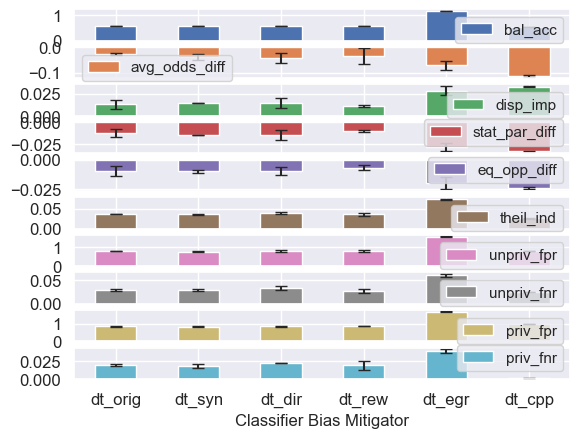

In [88]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
egr_error_metrics = {k: [statistics.stdev(v)] for (k,v) in egr_metrics.items()}
pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
egr_metrics_mean = {k:[sum(v)/N] for (k,v) in egr_metrics.items()}
pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

if BASELINE == 'lr':
    plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print("5)")
    print(stat)
else:
    plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print(stat)

plt.show()

# Visualization

### Fairness

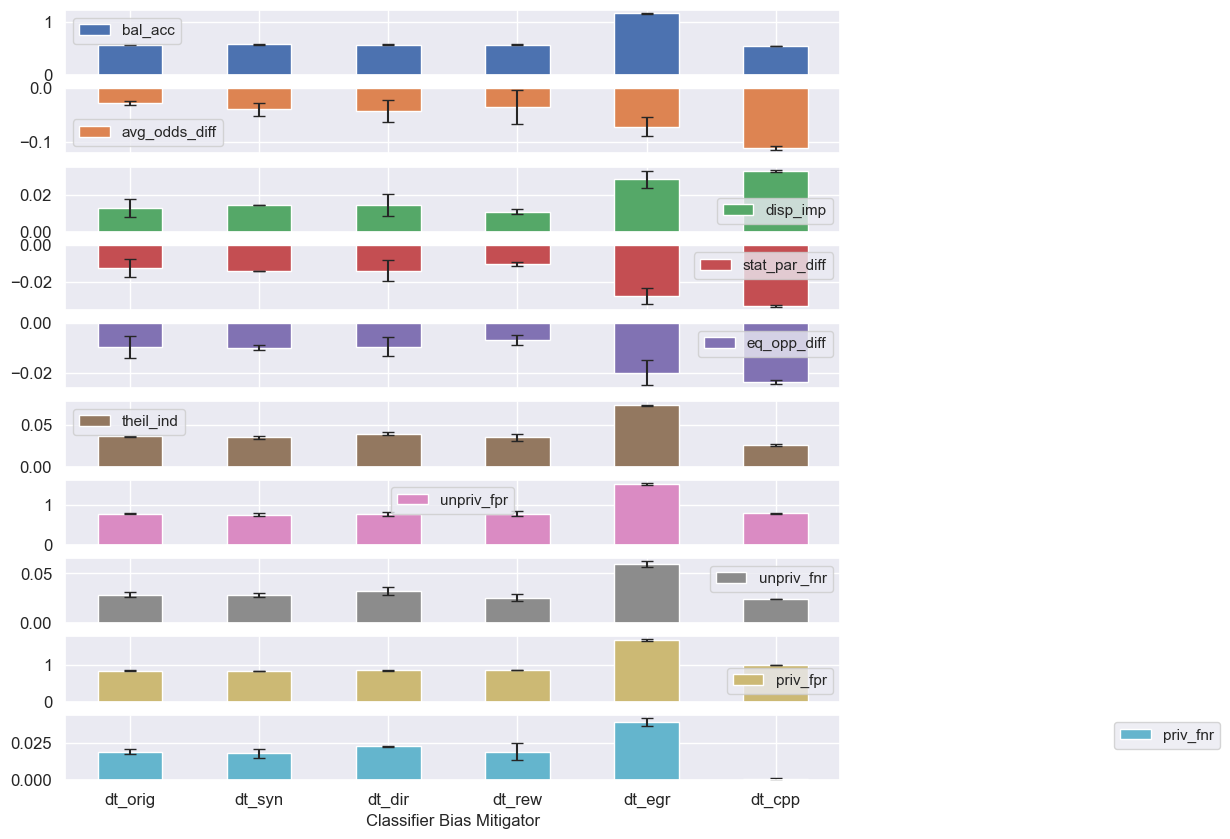

In [89]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        egr_metrics_mean,
        pr_orig_metrics_mean,
        cpp_metrics_mean,
        ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        egr_error_metrics,
        pr_orig_error_metrics,
        cpp_error_metrics,
        ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn']+ [model_type+'_dir']+ [model_type+'_rew']+ [model_type+'_egr'] + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

In [90]:
df

,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind,unpriv_fpr,unpriv_fnr,priv_fpr,priv_fnr
Classifier Bias Mitigator,,,,,,,,,,
dt_orig,0.579704,-0.026783,0.012890,-0.012564,-0.009576,0.036575,0.794464,0.028788,0.838454,0.019212
dt_syn,0.587440,-0.038866,0.014455,-0.014098,-0.009890,0.035532,0.767437,0.028131,0.835279,0.018241
dt_dir,0.578576,-0.042928,0.014482,-0.014068,-0.009473,0.040005,0.776591,0.032236,0.852975,0.022763
dt_rew,0.575719,-0.034569,0.010776,-0.010506,-0.006666,0.035449,0.794004,0.025840,0.856476,0.019174
dt_egr,1.171803,-0.071203,0.028481,-0.027744,-0.020082,0.074078,1.544827,0.059436,1.667150,0.039355
dt_cpp,0.543616,-0.111052,0.033002,-0.032975,-0.023860,0.025859,0.799211,0.024584,0.997455,0.000724


## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [91]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [92]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.517518,0.701894,0.511424,0.691854,0.515708,0.717851,0.509501
syn,0.514873,0.666069,0.510672,0.665059,0.516062,0.667672,0.508386
dir,0.521909,0.699202,0.515934,0.690202,0.524561,0.710677,0.512988
rew,0.516764,0.679430,0.512225,0.663773,0.515655,0.698856,0.510566
egr,0.517790,0.699028,0.511470,0.690099,0.515288,0.713451,0.510090


In [93]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [94]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [95]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.691854,0.515708,0.717851,0.509501
syn,0.665059,0.516062,0.667672,0.508386
dir,0.690202,0.524561,0.710677,0.512988
rew,0.663773,0.515655,0.698856,0.510566
egr,0.690099,0.515288,0.713451,0.510090


<Axes: xlabel='Classifier MIA Attacks'>

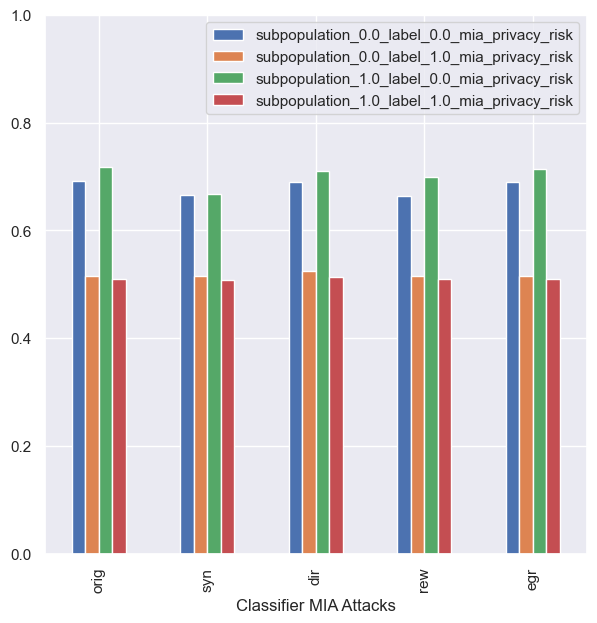

In [96]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [97]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew       egr
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.691854  0.665059  0.690202  0.663773  0.690099
subpopulation_0.0_label_1.0_mia_privacy_risk  0.515708  0.516062  0.524561  0.515655  0.515288
subpopulation_1.0_label_0.0_mia_privacy_risk  0.717851  0.667672  0.710677  0.698856  0.713451
subpopulation_1.0_label_1.0_mia_privacy_risk  0.509501  0.508386  0.512988  0.510566  0.51009


### Visualizing using novel technique

In [98]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [99]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])

In [100]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.516300
1,orig,entire_dataset_mia_privacy_risk,0.518127
2,orig,entire_dataset_mia_privacy_risk,0.518127
3,orig,entire_dataset_label_0.0_mia_privacy_risk,0.685704
4,orig,entire_dataset_label_0.0_mia_privacy_risk,0.709989
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.725438
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.725438
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.514265
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.508002


In [101]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.516300
1,orig,entire_dataset_mia_privacy_risk,0.518127
2,orig,entire_dataset_mia_privacy_risk,0.518127
9,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.683647
10,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.695957
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.725438
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.725438
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.514265
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.508002


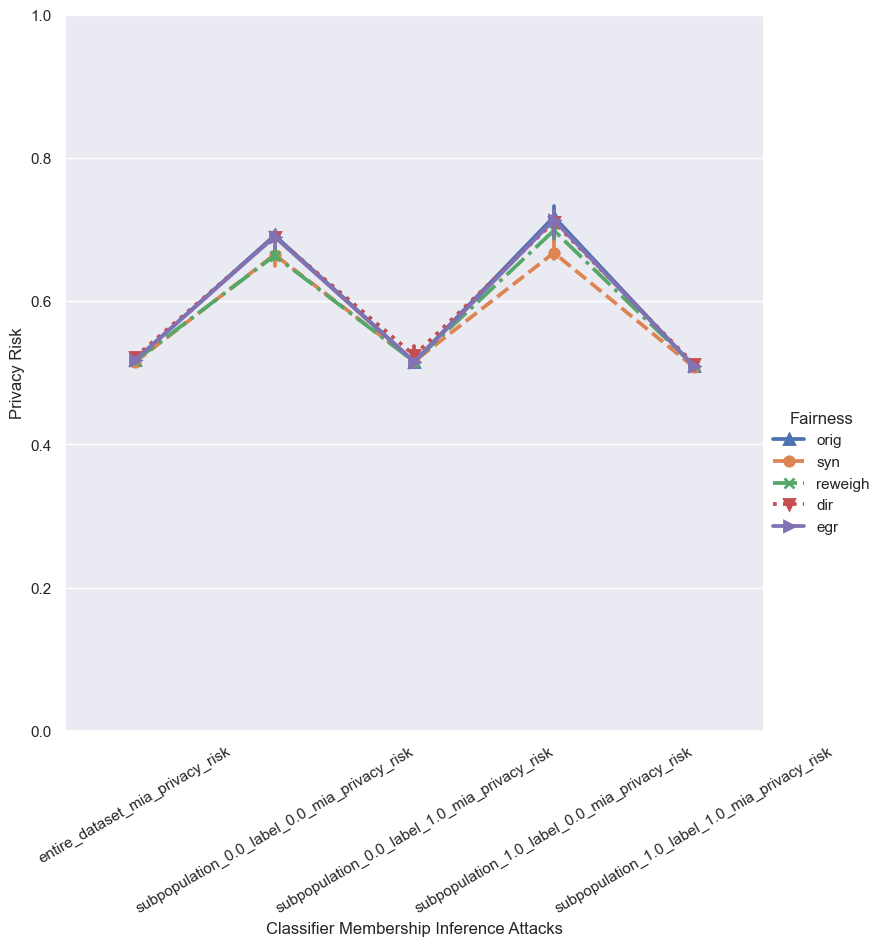

In [102]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [103]:
from sklearn.metrics import RocCurveDisplay, auc

In [104]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

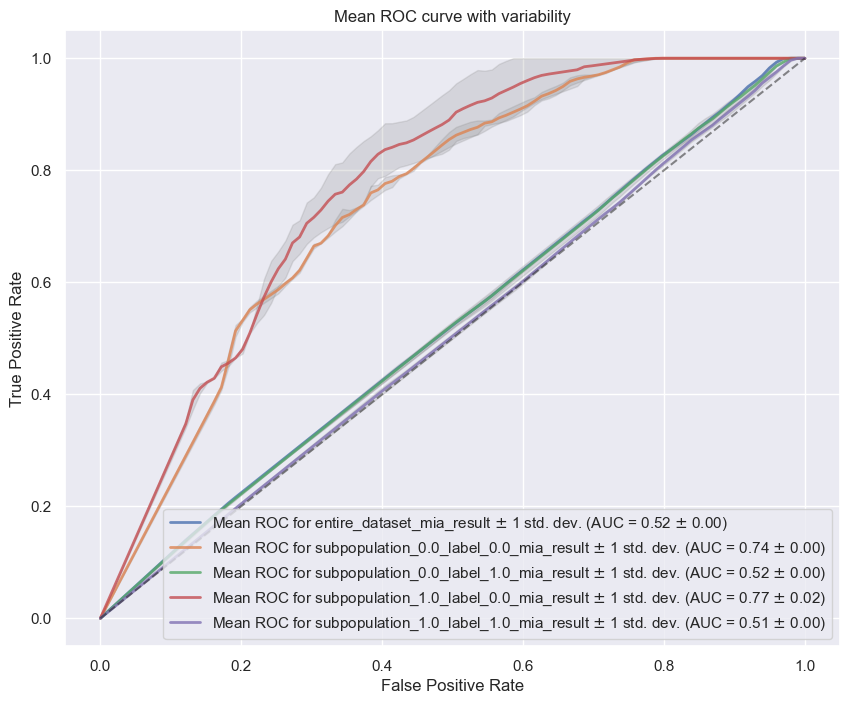

In [105]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result", "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

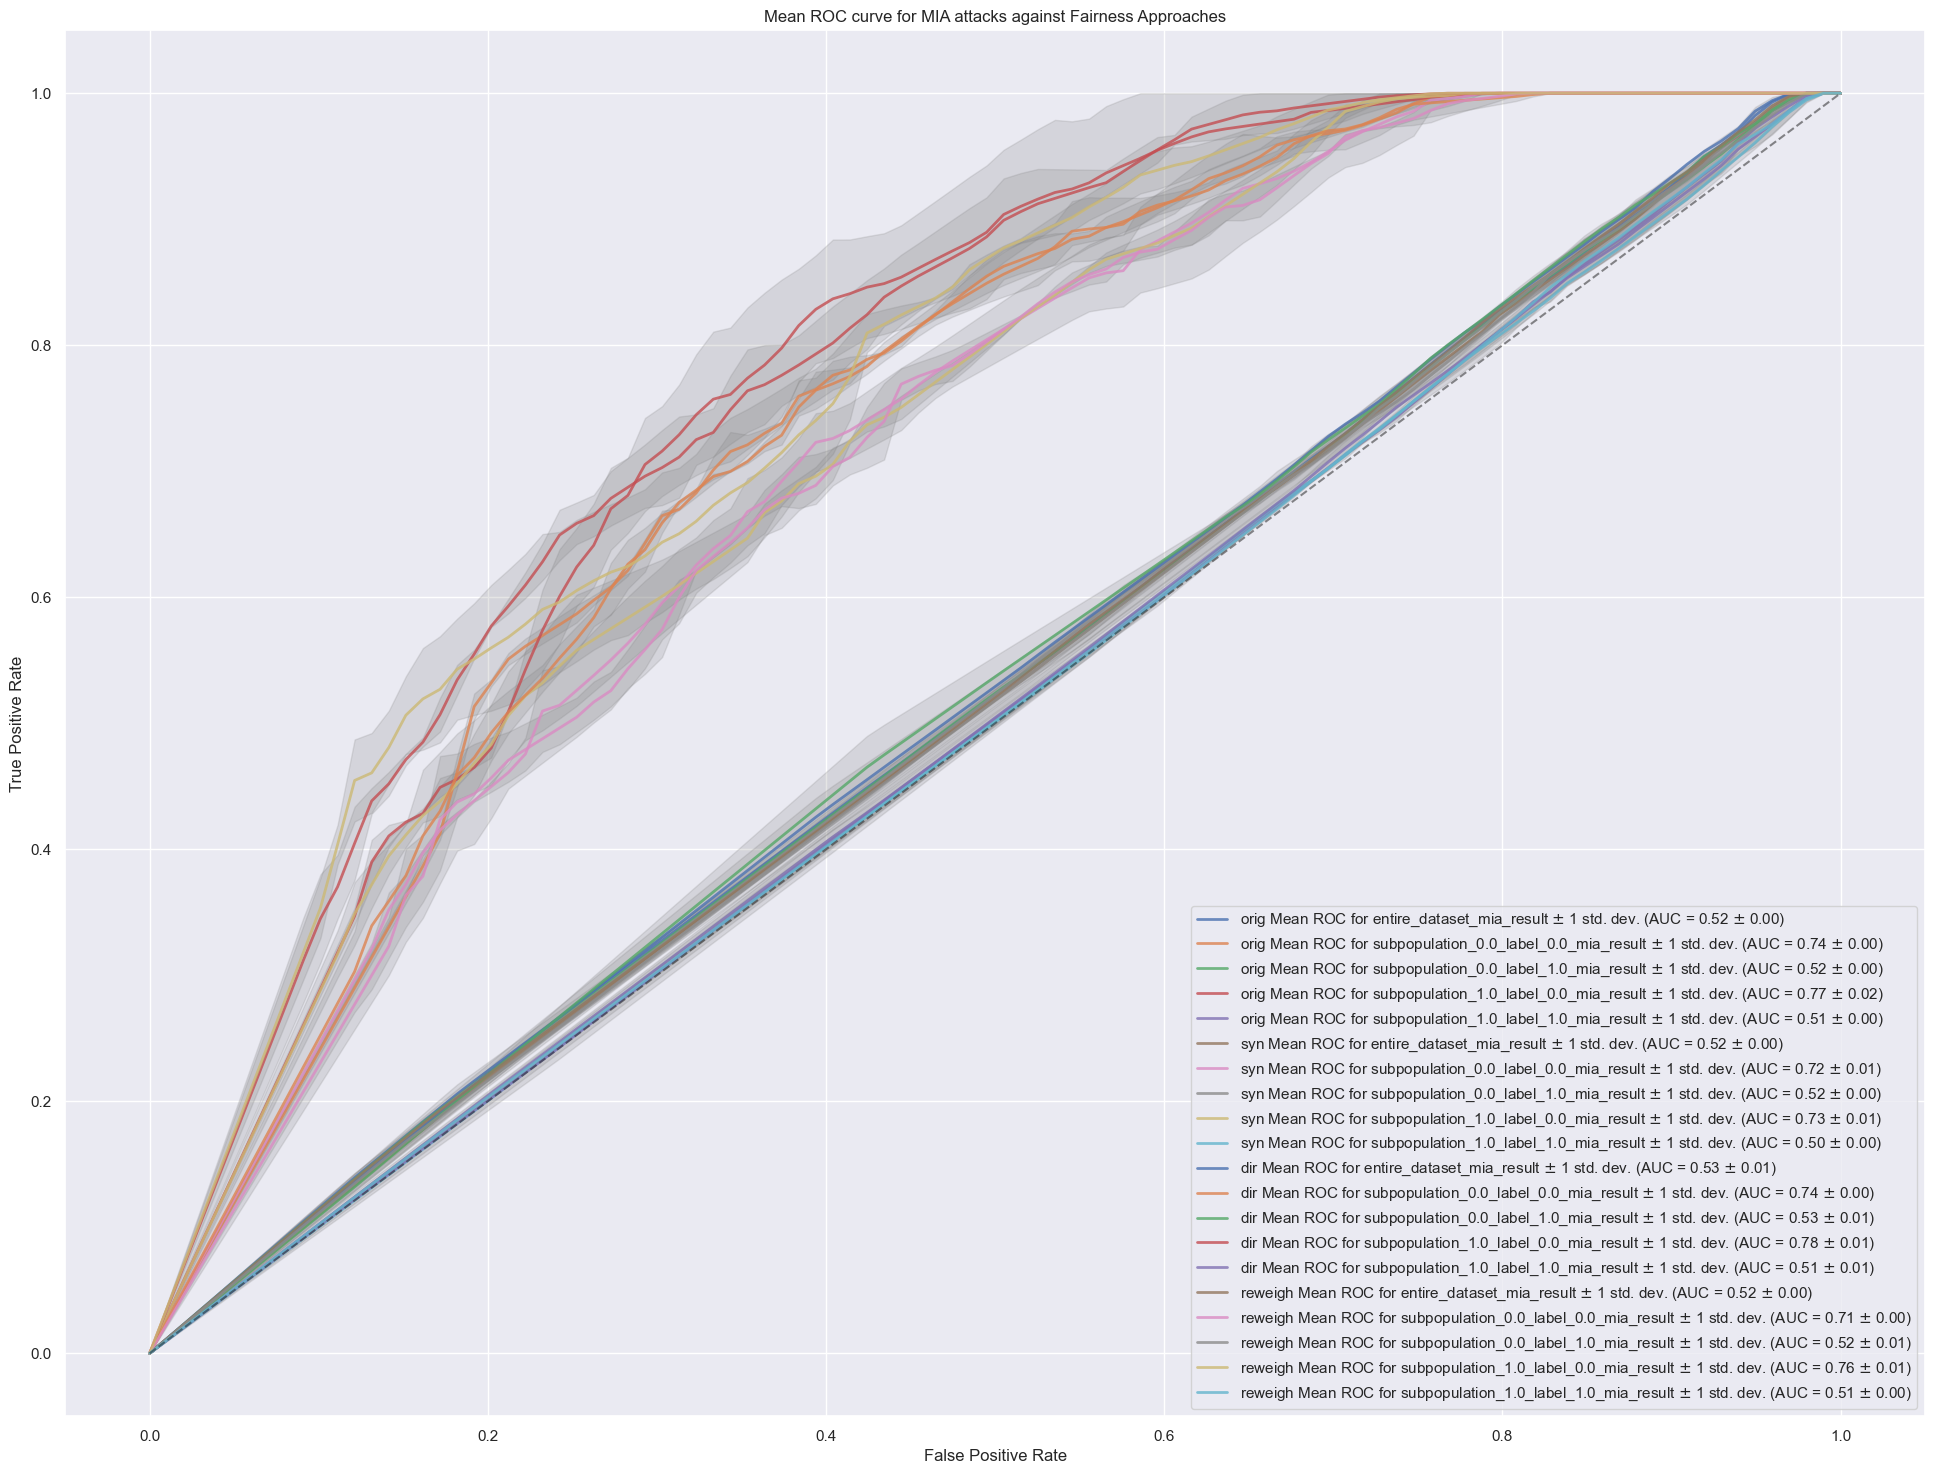

In [106]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics, dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

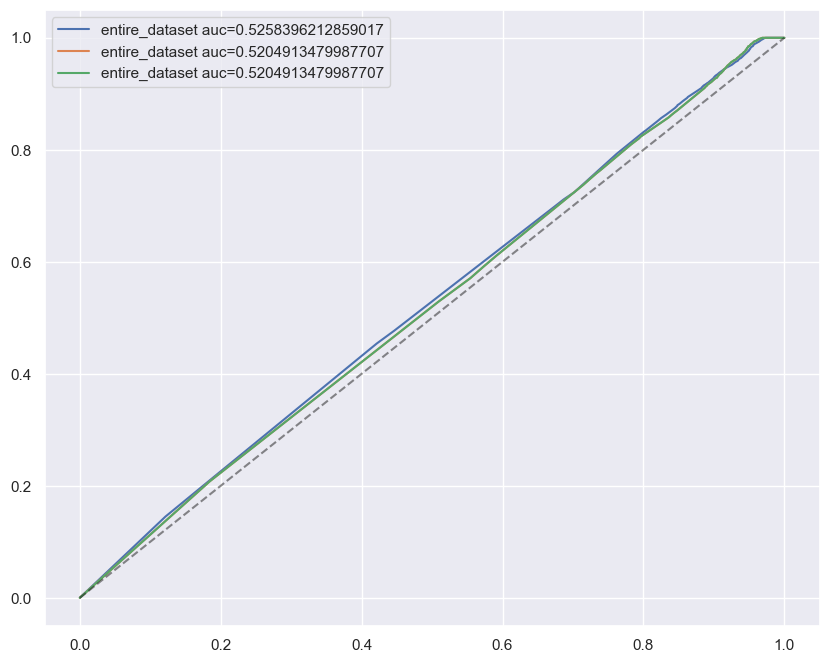

In [107]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [108]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}

In [109]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.5222741057611476,
 'entire_dataset_label_0.0_mia_auc': 0.7556709593152847,
 'entire_dataset_label_1.0_mia_auc': 0.5130143407516754,
 'subpopulation_0.0_label_0.0_mia_auc': 0.7423202999681221,
 'subpopulation_0.0_label_1.0_mia_auc': 0.5208583782049451,
 'subpopulation_1.0_label_0.0_mia_auc': 0.7686511560913859,
 'subpopulation_1.0_label_1.0_mia_auc': 0.5061373699407631}

In [110]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.522274,0.755671,0.513014,0.742320,0.520858,0.768651,0.506137
syn,0.519246,0.723104,0.511415,0.718179,0.520652,0.726774,0.504130
dir,0.525467,0.759769,0.515708,0.740031,0.526521,0.778663,0.506639
rew,0.520461,0.740168,0.511189,0.712514,0.518207,0.764103,0.505559


<Axes: xlabel='Classifier MIA Attacks'>

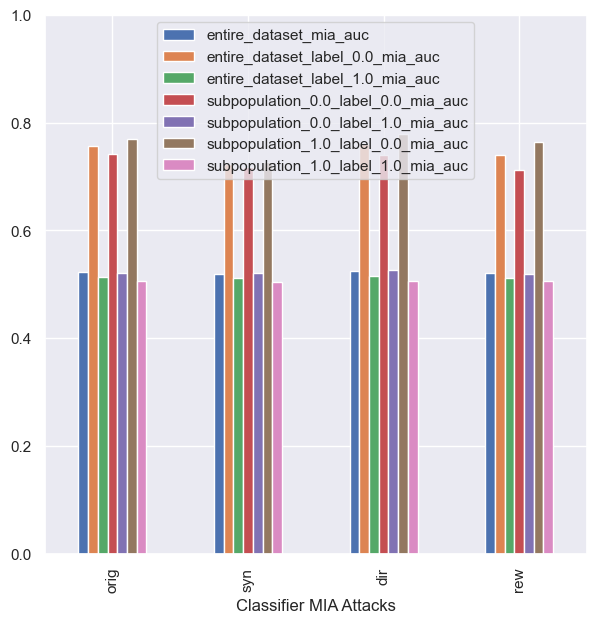

In [111]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [112]:
# Creating data structures to plot point categorical plot from seaborn

In [113]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [114]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.03259928839311471,
  0.036253485912106864,
  0.036253485912106864],
 'entire_dataset_label_0.0_mia_attacker_advantage': [0.37140804597701144,
  0.41997780244173144,
  0.41997780244173144],
 'entire_dataset_label_1.0_mia_attacker_advantage': [0.02694097196267231,
  0.020800487191184214,
  0.020800487191184214],
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': [0.367293915075485,
  0.3919143409447868,
  0.3919143409447868],
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': [0.03972855835290923,
  0.027258877317612007,
  0.027258877317612007],
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': [0.37482113132611045,
  0.4661422807883203,
  0.4661422807883203],
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': [0.025000804505229235,
  0.01600364451663283,
  0.01600364451663283]}

In [115]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.03259928839311471],
 ['orig', 'entire_dataset', 0.036253485912106864],
 ['orig', 'entire_dataset', 0.036253485912106864],
 ['orig', 'entire_dataset_label_0.0', 0.37140804597701144],
 ['orig', 'entire_dataset_label_0.0', 0.41997780244173144],
 ['orig', 'entire_dataset_label_0.0', 0.41997780244173144],
 ['orig', 'entire_dataset_label_1.0', 0.02694097196267231],
 ['orig', 'entire_dataset_label_1.0', 0.020800487191184214],
 ['orig', 'entire_dataset_label_1.0', 0.020800487191184214],
 ['orig', 'subpopulation_0.0_label_0.0', 0.367293915075485],
 ['orig', 'subpopulation_0.0_label_0.0', 0.3919143409447868],
 ['orig', 'subpopulation_0.0_label_0.0', 0.3919143409447868],
 ['orig', 'subpopulation_0.0_label_1.0', 0.03972855835290923],
 ['orig', 'subpopulation_0.0_label_1.0', 0.027258877317612007],
 ['orig', 'subpopulation_0.0_label_1.0', 0.027258877317612007],
 ['orig', 'subpopulation_1.0_label_0.0', 0.37482113132611045],
 ['orig', 'subpopulation_1.0_label_0.0', 0.4661

In [116]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.032599
1,orig,entire_dataset,0.036253
2,orig,entire_dataset,0.036253
3,orig,entire_dataset_label_0.0,0.371408
4,orig,entire_dataset_label_0.0,0.419978
...,...,...,...
100,egr,subpopulation_1.0_label_0.0,0.450875
101,egr,subpopulation_1.0_label_0.0,0.450875
102,egr,subpopulation_1.0_label_1.0,0.028531
103,egr,subpopulation_1.0_label_1.0,0.016004


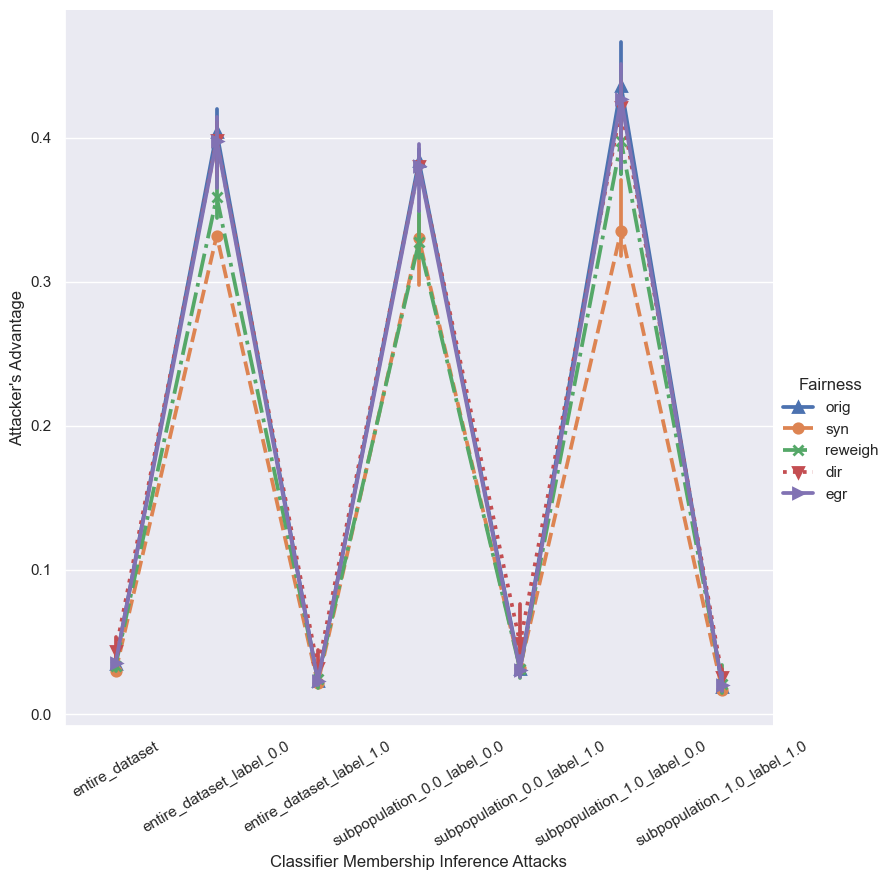

In [117]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


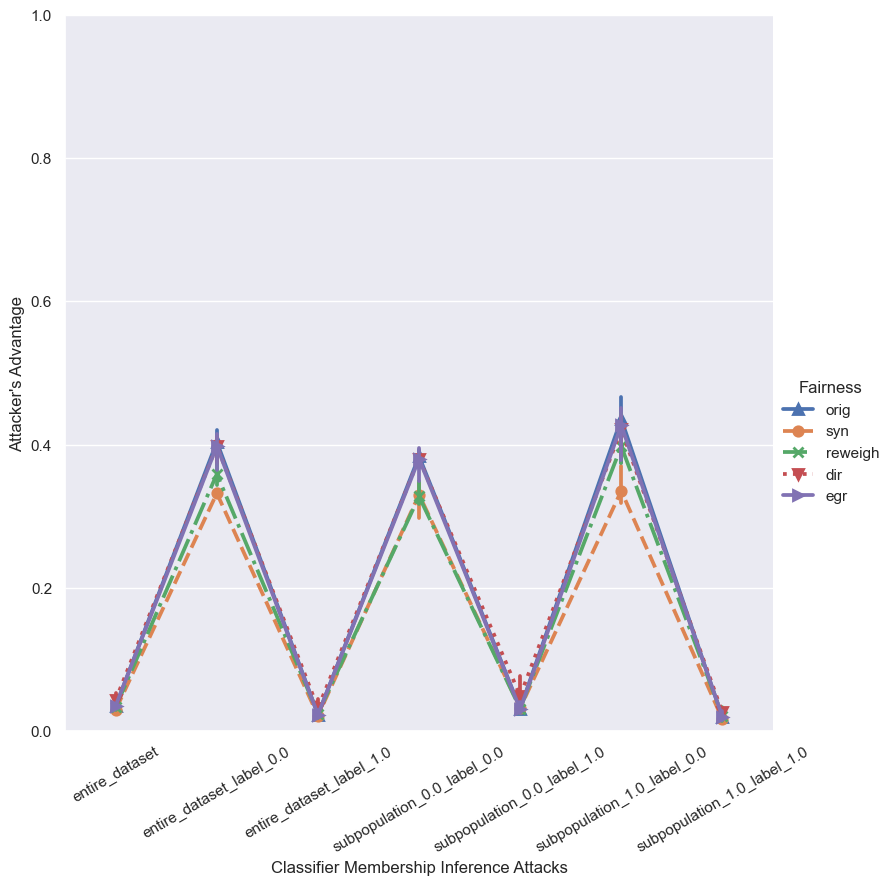

In [118]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [119]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.032599,0.371408,0.026941,0.367294,0.039729,0.374821,0.025001
1,0.036253,0.419978,0.020800,0.391914,0.027259,0.466142,0.016004
2,0.036253,0.419978,0.020800,0.391914,0.027259,0.466142,0.016004


In [120]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [121]:
orig_mia_metrics_mean

{'entire_dataset_mia_attacker_advantage': 0.03503542007244281,
 'entire_dataset_label_0.0_mia_attacker_advantage': 0.4037878836201581,
 'entire_dataset_label_1.0_mia_attacker_advantage': 0.02284731544834691,
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': 0.38370753232168614,
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': 0.03141543766271108,
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': 0.4357018976342504,
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': 0.019002697846164967}

In [122]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.035035,0.403788,0.022847,0.383708,0.031415,0.435702,0.019003
syn,0.029746,0.332138,0.021345,0.330117,0.032124,0.335344,0.016772
dir,0.043818,0.398405,0.031868,0.380405,0.049123,0.421354,0.025975
rew,0.033529,0.358860,0.024449,0.327547,0.031310,0.397712,0.021133
egr,0.035580,0.398056,0.022941,0.380198,0.030576,0.426901,0.020179


<Axes: xlabel='Classifier MIA Attacks'>

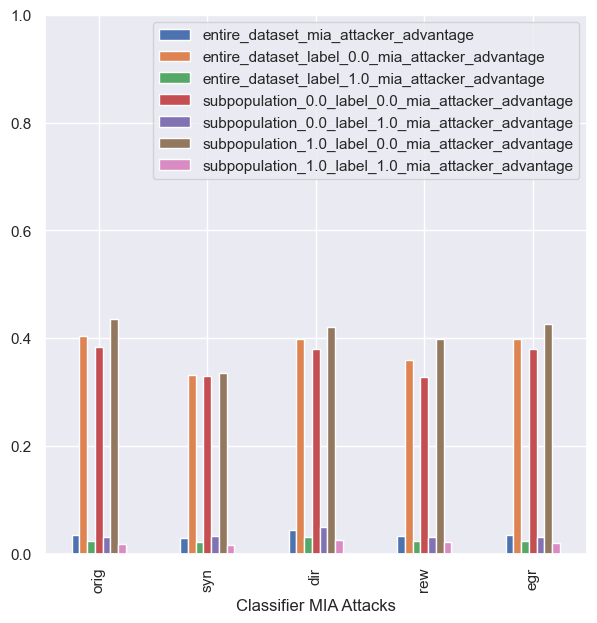

In [123]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [124]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("mia_ppv")}

In [125]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5439798125450612],
 ['orig', 'entire_dataset', 0.5300171526586621],
 ['orig', 'entire_dataset', 0.5300171526586621],
 ['orig', 'entire_dataset_label_0.0', 0.7771428571428571],
 ['orig', 'entire_dataset_label_0.0', 0.7417218543046357],
 ['orig', 'entire_dataset_label_0.0', 0.7417218543046357],
 ['orig', 'entire_dataset_label_1.0', 0.5168084244633455],
 ['orig', 'entire_dataset_label_1.0', 0.5155018392012612],
 ['orig', 'entire_dataset_label_1.0', 0.5155018392012612],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7857142857142857],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7401129943502825],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7401129943502825],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5320623916811091],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5266311584553928],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5266311584553928],
 ['orig', 'subpopulation_1.0_label_0.0', 0.7671232876712328],
 ['orig', 'subpopulation_1.0_label_0.0', 0.7553956834532375],
 ['

In [126]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.543980
1,orig,entire_dataset,0.530017
2,orig,entire_dataset,0.530017
3,orig,entire_dataset_label_0.0,0.777143
4,orig,entire_dataset_label_0.0,0.741722
...,...,...,...
100,egr,subpopulation_1.0_label_0.0,0.748148
101,egr,subpopulation_1.0_label_0.0,0.748148
102,egr,subpopulation_1.0_label_1.0,0.510836
103,egr,subpopulation_1.0_label_1.0,0.509770


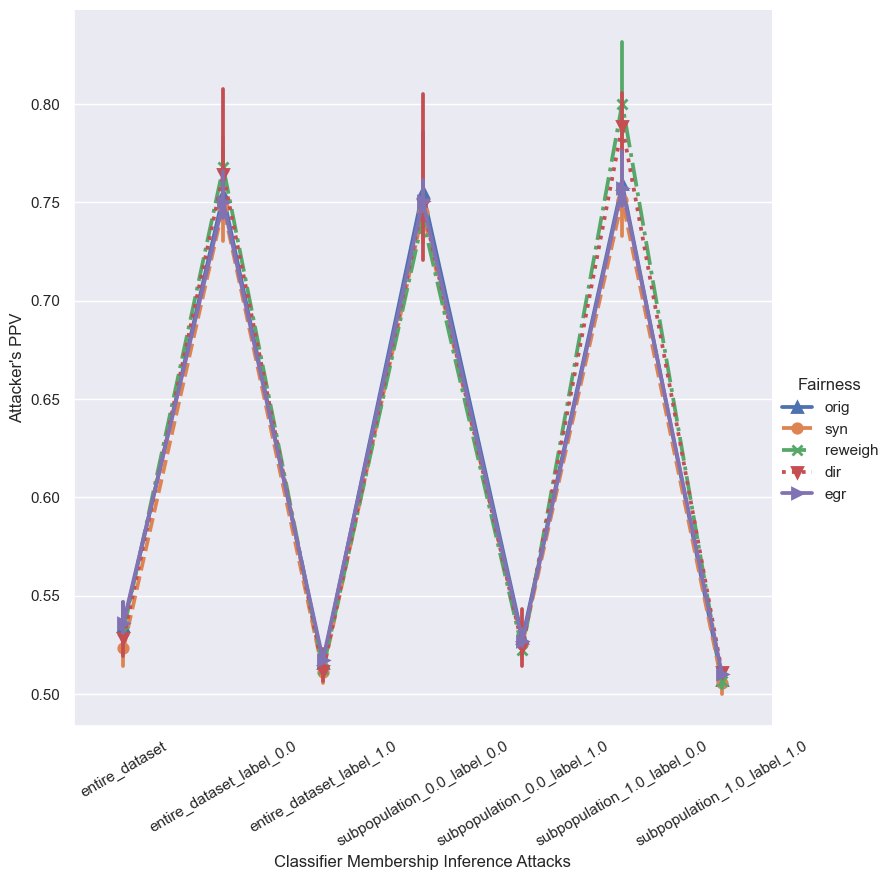

In [127]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [128]:
import pandas as pd

In [129]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

,decile3,decile1,race,cluster,lsat,ugpa,dob_yr,fulltime,fam_inc,age,gender,race2,other,asian,black,hisp,tier,indxgrp,indxgrp2,labels
0,10.0,10.0,7.0,1.0,44.0,3.5,69.0,1.0,5.0,-62.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0,1.0
1,4.0,5.0,7.0,2.0,29.0,3.5,69.0,1.0,4.0,-62.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,5.0,1.0
2,7.0,8.0,7.0,1.0,37.0,3.4,68.0,1.0,3.0,-61.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,7.0,1.0
3,7.0,8.0,7.0,1.0,43.0,3.3,67.0,1.0,4.0,-60.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0,1.0
4,2.0,3.0,7.0,4.0,41.0,3.3,64.0,1.0,4.0,-57.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,6.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20793,8.0,9.0,7.0,5.0,42.0,3.0,67.0,1.0,4.0,-60.0,1.0,1.0,0.0,0.0,0.0,0.0,6.0,6.0,7.0,1.0
20794,9.0,4.0,7.0,3.0,29.5,3.5,68.0,1.0,4.0,-61.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,5.0,5.0,1.0
20795,1.0,1.0,3.0,3.0,33.0,3.1,69.0,1.0,3.0,-62.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,5.0,5.0,0.0
20796,5.0,4.0,7.0,3.0,32.0,3.0,67.0,0.0,3.0,-65.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,5.0,5.0,1.0


In [130]:
df[["age", "labels"]].value_counts(normalize=True)

age    labels
-62.0  1.0       0.245841
-61.0  1.0       0.171603
-60.0  1.0       0.100635
-59.0  1.0       0.069478
-58.0  1.0       0.048418
                   ...   
-24.0  1.0       0.000048
-26.0  1.0       0.000048
-28.0  0.0       0.000048
-33.0  0.0       0.000048
-3.0   1.0       0.000048
Name: proportion, Length: 95, dtype: float64

In [131]:
df.drop_duplicates()

,decile3,decile1,race,cluster,lsat,ugpa,dob_yr,fulltime,fam_inc,age,gender,race2,other,asian,black,hisp,tier,indxgrp,indxgrp2,labels
0,10.0,10.0,7.0,1.0,44.0,3.5,69.0,1.0,5.0,-62.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0,1.0
1,4.0,5.0,7.0,2.0,29.0,3.5,69.0,1.0,4.0,-62.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,5.0,1.0
2,7.0,8.0,7.0,1.0,37.0,3.4,68.0,1.0,3.0,-61.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,7.0,1.0
3,7.0,8.0,7.0,1.0,43.0,3.3,67.0,1.0,4.0,-60.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0,1.0
4,2.0,3.0,7.0,4.0,41.0,3.3,64.0,1.0,4.0,-57.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,6.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20793,8.0,9.0,7.0,5.0,42.0,3.0,67.0,1.0,4.0,-60.0,1.0,1.0,0.0,0.0,0.0,0.0,6.0,6.0,7.0,1.0
20794,9.0,4.0,7.0,3.0,29.5,3.5,68.0,1.0,4.0,-61.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,5.0,5.0,1.0
20795,1.0,1.0,3.0,3.0,33.0,3.1,69.0,1.0,3.0,-62.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,5.0,5.0,0.0
20796,5.0,4.0,7.0,3.0,32.0,3.0,67.0,0.0,3.0,-65.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,5.0,5.0,1.0
